### Imports

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
import torch
import torchaudio
import torchaudio.transforms as T

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch import nn

# to play the audio files
from IPython.display import Audio

In [2]:
# Base directory
base_dir_tess = "./TESS"

# Lists to store file paths and emotions from the filename
file_paths = []
emotions = []

for emotions_folder in sorted(glob.glob(os.path.join(base_dir_tess, "YAF_*"))):
    wav_files = glob.glob(os.path.join(emotions_folder, "*.wav"))

    for wav_file in wav_files:
        file_paths.append(wav_file)
        
        filename = os.path.basename(wav_file)
        
        # Split by '_' and get the third number
        parts = filename.split('_')
        if len(parts) >= 3:
            emotion = (parts[2])[:-4]
            if emotion == "ps":
                emotions.append("surprised")
            else:
                emotions.append(emotion)
        else:
            print(f"Warning: unexpected filename format: {filename}")

# Check if both lists are equal in length
print(f"Collected {len(file_paths)} files.")
print(f"Collected {len(emotions)} labels.")
print("Example:", file_paths[200], "->", emotions[200])

Collected 2800 files.
Collected 2800 labels.
Example: ./TESS\YAF_angry\YAF_back_angry.wav -> angry


In [3]:
# Base directory
base_dir = "./archive"

# Lists to store file paths and emotions from the filename
#file_paths = []
#emotions = []

emotions_dict ={
    "01" : "neutral",
    "02" : "calm",
    "03" : "happy",
    "04" : "sad",
    "05" : "angry",
    "06" : "fear",
    "07" : "disgust",
    "08" : "surprised"
}

# Loop over all Actor_XX folders
for actor_folder in sorted(glob.glob(os.path.join(base_dir, "Actor_*"))):
    wav_files = glob.glob(os.path.join(actor_folder, "*.wav"))
    
    for wav_file in wav_files:
        # Append full path to the list
        file_paths.append(wav_file)
        
        # Extract filename (without folder)
        filename = os.path.basename(wav_file)
        
        # Split by '-' and get the third number
        parts = filename.split('-')
        if len(parts) >= 3:
            emotion_number = parts[2]
            emotions.append(emotions_dict[emotion_number])
        else:
            print(f"Warning: unexpected filename format: {filename}")

# Check if both lists are equal in length
print(f"Collected {len(file_paths)} files.")
print(f"Collected {len(emotions)} labels.")
print("Example:", file_paths[3000], "->", emotions[3000])

Collected 4240 files.
Collected 4240 labels.
Example: ./archive\Actor_04\03-01-04-01-01-01-04.wav -> sad


In [4]:
x_train_paths, x_temp_paths, y_train_emotions, y_temp = train_test_split(
    file_paths, emotions, test_size=0.3, random_state=45, shuffle=True
)

x_val_paths, x_test_paths, y_val_emotions, y_test_emotions = train_test_split(
    x_temp_paths, y_temp, test_size=0.5, random_state=45, shuffle=True
)

print(len(x_train_paths), len(x_val_paths), len(x_test_paths))
print(len(y_train_emotions), len(y_val_emotions), len(y_test_emotions))

2968 636 636
2968 636 636


In [50]:
torch.save(
    {
        "x_train_paths": x_train_paths,
        "x_val_paths": x_val_paths,
        "x_test_paths": x_test_paths,
        "y_train_emotions": y_train_emotions,
        "y_val_emotions": y_val_emotions,
        "y_test_emotions": y_test_emotions,
    },
    "./paths_emotions.ckpt",
)

### Ploting Functions

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(15, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

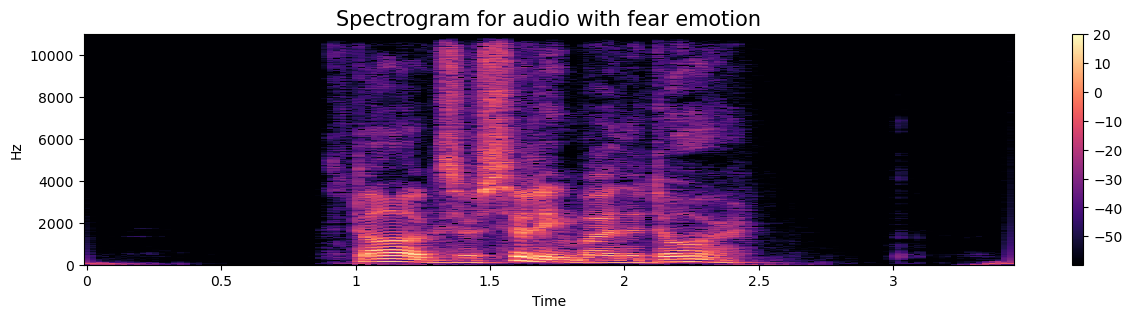

In [6]:
%matplotlib inline

path = "./archive/Actor_01/03-01-06-01-02-01-01.wav"

data, sampling_rate = librosa.load(path)

#create_waveplot(data, sampling_rate, 'fear')
create_spectrogram(data, sampling_rate, 'fear')

Audio(path)

### Augmentation 

In [7]:
def noise(waveform, noise_factor=0.05):
    """
    Adds Gaussian noise to a waveform tensor.
    waveform: torch.Tensor (1, num_samples)
    """
    noise = torch.randn_like(waveform)
    augmented = waveform + noise_factor * noise * waveform.abs().max()
    return augmented.clamp(-1.0, 1.0)

def shift(waveform, sampling_rate, n_steps=2):
    """
    Shifts pitch by n_steps semitones without changing duration.
    """
    transform = T.PitchShift(sample_rate=sampling_rate, n_steps=n_steps)
    return transform(waveform)

In [8]:
def extract_melspectrogram(waveform, sampling_rate):
    """
    Computes mean Mel-spectrogram features for a waveform tensor.
    Returns a 1D NumPy array.
    """
    mel_transform = T.MelSpectrogram(
        sample_rate=sampling_rate,
        n_mels=128,
        n_fft=2048,
        hop_length=512
    )
    mel_spec = mel_transform(waveform)                # shape: (1, n_mels, time)
    mel_db = T.AmplitudeToDB()(mel_spec)              # convert to dB scale
    #mel_mean = torch.mean(mel_db, dim=-1).squeeze(0)  # average across time
    #return mel_mean.detach().numpy()                  # return as NumPy array
    return mel_db.squeeze(0).detach().numpy()

def get_feature(path, data_origin, augment, duration=3, offset=0.5):
    """
    Loads an audio file, extracts features with and without augmentations.
    Returns a 2D NumPy array: [original, pitch-shifted, noise-augmented].
    """
    # Load audio
    data, sr = librosa.load(path)
    waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
    target_len = int(sr * duration)
    
    if data_origin.upper() == "RAVDESS":
        # Clip starting from offset
        start = int(offset * sr)
        end = start + target_len
        waveform = waveform[:, start:end]

        # If shorter, pad at the end
        if waveform.shape[1] < target_len:
            pad_len = target_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))

    elif data_origin.upper() == "TESS":
        cur_len = waveform.shape[1]
        if cur_len < target_len:
            pad_total = target_len - cur_len
            pad_start = pad_total // 2
            pad_end = pad_total - pad_start
            waveform = torch.nn.functional.pad(waveform, (pad_start, pad_end))
        else:
            # Should not get here
            print("A clip in TESS is of weird length")
            start = (cur_len - target_len) // 2
            waveform = waveform[:, start:start + target_len]

    # If shorter, pad with zeros
    if waveform.shape[1] < target_len:
        pad_len = target_len - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_len))

    # no augmentation
    base_features = extract_melspectrogram(waveform, sr)       # (128, time)
    result = np.expand_dims(base_features, axis=0)            # (1, 128, time)

    if augment:
        # Pitch-shifted
        pitched = shift(waveform, sr, n_steps=2)
        pitched_features = extract_melspectrogram(pitched, sr)
        result = np.vstack((result, np.expand_dims(pitched_features, axis=0)))
    
        # Noise-augmented
        noised = noise(waveform, noise_factor=0.05)
        noised_features = extract_melspectrogram(noised, sr)
        result = np.vstack((result, np.expand_dims(noised_features, axis=0)))

    return result

def extract_dataset_features(file_paths, emotions, augment):
    audio_files_features, corresponding_emotions = [], []
    
    for path, emotion in zip(file_paths, emotions):
        # Detect dataset origin
        if path.startswith("./archive"):
            origin = "RAVDESS"
        elif path.startswith("./TESS"):
            origin = "TESS"
        else:
            print("WRONG FILENAME FORMAT")
            continue
        
        feature = get_feature(path, origin, augment)
        
        # If augment=True, get_feature returns multiple variants vertically stacked (base, pitch, noise)
        for audio_file in feature:
            audio_files_features.append(audio_file)
            corresponding_emotions.append(emotion)
    
    return np.array(audio_files_features), np.array(corresponding_emotions)

In [47]:
# Train is the only set augmented
x_train_features, y_train_corresponding_emotions = extract_dataset_features(x_train_paths, y_train_emotions, True)

# Validation & test without augmentation
x_val_features, y_val_corresponding_emotions = extract_dataset_features(x_val_paths, y_val_emotions, False)
x_test_features, y_test_corresponding_emotions = extract_dataset_features(x_test_paths, y_test_emotions, False)

#checkpoint = torch.load("features_split_2d.ckpt", weights_only=False)
#x_train_features, y_train_corresponding_emotions = checkpoint["x_train_features"], checkpoint["y_train_corresponding_emotions"]
#x_val_features, y_val_corresponding_emotions = checkpoint["x_val_features"], checkpoint["y_val_corresponding_emotions"]
#x_test_features, y_test_corresponding_emotions = checkpoint["x_test_features"], checkpoint["y_test_corresponding_emotions"]

print(len(x_train_features), len(y_train_corresponding_emotions))
print(len(x_val_features), len(y_val_corresponding_emotions))
print(len(x_test_features), len(y_test_corresponding_emotions))

8904 8904
636 636
636 636


In [52]:
torch.save(
    {
        "x_train_features": x_train_features,
        "x_val_features": x_val_features,
        "x_test_features": x_test_features,
        "y_train_corresponding_emotions": y_train_corresponding_emotions,
        "y_val_corresponding_emotions": y_val_corresponding_emotions,
        "y_test_corresponding_emotions": y_test_corresponding_emotions,
    },
    "./features_split_2d.ckpt",
)

In [11]:
#df = pd.DataFrame(audio_files_features)
#df['emotions'] = corresponding_emotions
#df.tail()

In [12]:
print(len(x_train_features[0]))

128


In [13]:
#encoder = OneHotEncoder()
#encoded_emotions = encoder.fit_transform(np.array(df['emotions'].values).reshape(-1, 1)).toarray()

In [14]:
#audio_files_features = df.iloc[: ,:-1].values

#x_train, x_temp, y_train, y_temp = train_test_split(audio_files_features, encoded_emotions, test_size=0.3, random_state=45, shuffle=True)

#x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=45, shuffle=True)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train_corresponding_emotions.reshape(-1, 1)).toarray()
y_val   = encoder.transform(y_val_corresponding_emotions.reshape(-1, 1)).toarray()
y_test  = encoder.transform(y_test_corresponding_emotions.reshape(-1, 1)).toarray()

# Change from one hot encoding to class indices
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)

x_train = np.expand_dims(x_train_features, axis=1)
x_val   = np.expand_dims(x_val_features, axis=1)
x_test  = np.expand_dims(x_test_features, axis=1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((8904, 1, 128, 130),
 (8904,),
 (636, 1, 128, 130),
 (636,),
 (636, 1, 128, 130),
 (636,))

# CNN

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((4, 4)),
            #nn.Dropout(p=0.3),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 130) #(batch, channel, frequency, time)
            out = self.cnn(dummy)
            n_flatten = out.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
            # No activation since we use CrossEntropyLoss
        )
    def forward(self, input_batch):
        output = self.cnn(input_batch)
        output = self.classifier(output)         
        return output

# CNN-GRU

In [23]:
class CNN_GRU(nn.Module):
    def __init__(self):
        super(CNN_GRU, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 130) #(batch, channel, frequency, time)
            out = self.cnn(dummy) #(batch, channel, frequency, time)
            B, C, F, T = out.shape
            gru_input_size = C * F

        self.gru = nn.GRU(input_size=gru_input_size, hidden_size=128, num_layers=2, batch_first=True, birectional=True)

        self.drop = nn.Dropout(p=0.3)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 8)
            # No activation since we use CrossEntropyLoss
        )
    def forward(self, input_batch):
        output = self.cnn(input_batch) #B, C, F, T
        output = output.permute(0, 3, 1, 2) #B, T, C, F
        batch, time, channels, frequency = output.shape
        output = output.reshape(batch, time, channels*frequency)
        output, _ = self.gru(output)
        output = self.drop(output)
        output = output[:, -1, :]            
        output = self.classifier(output)         
        return output

In [16]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every, scheduler
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        scheduler.step()
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        #train_losses.extend(train_loss)
        #train_accs.extend(train_acc)
        train_losses.append((sum(train_loss) / len(train_loss)))
        train_accs.append((sum(train_acc)/len(train_acc)))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = torch.argmax(z, dim=1)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )
    
    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = torch.argmax(z, dim=1)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

In [17]:
from torch.utils.data import Dataset, DataLoader

class AudioFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [18]:
#emotion_counts = df['emotions'].value_counts().sort_index()
from collections import Counter

emotion_counts = Counter(emotions)
emotion_counts = dict(sorted(emotion_counts.items()))
counts = torch.tensor(list(emotion_counts.values()), dtype=torch.float32)
w = 1.0 / counts
w = w / w.sum()

print(w)
print(list(emotion_counts.values()))

tensor([0.0973, 0.3000, 0.0973, 0.0973, 0.0973, 0.1161, 0.0973, 0.0973])
[592, 192, 592, 592, 592, 496, 592, 592]


In [53]:
torch.save(
    {
        "weights": w
    },
    "./weights.ckpt",
)

In [46]:
batch_size = 128
epochs = 50
prints = 71
learning_rate = 1e-4
weight_decay = 1e-4

train_dataset = AudioFeatureDataset(x_train, y_train)
val_dataset = AudioFeatureDataset(x_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = CNN()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

trained_model_cnn, train_losses_cnn, train_accs_cnn, val_losses_cnn, val_accs_cnn = training_loop(
    model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, prints, scheduler
)

Starting training
Epoch 1/50: Train loss: 1.780, Train acc.: 0.340, Val. loss: 1.739, Val. acc.: 0.409


KeyboardInterrupt: 

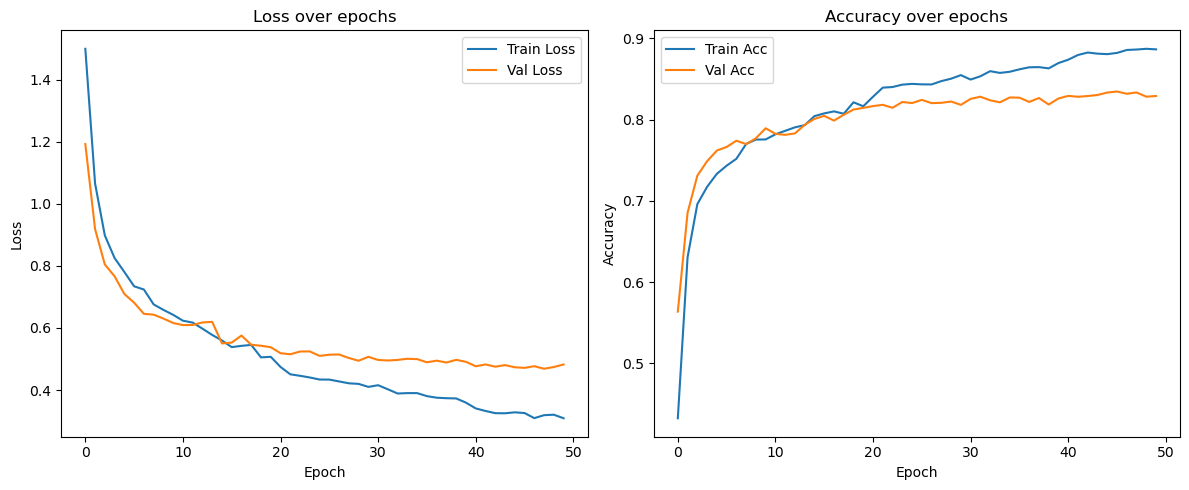

In [41]:
plot_loss_acc(train_losses_cnn, train_accs_cnn, val_losses_cnn, val_accs_cnn, "cnn_model")

### Saving CNN

In [42]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "train_losses_cnn": train_losses_cnn, 
        "train_accs_cnn": train_accs_cnn, 
        "val_losses_cnn": val_losses_cnn, 
        "val_accs_cnn": val_accs_cnn
    },
    "./cnn_model_checkpoint.ckpt",
)

In [24]:
batch_size = 128
epochs = 100
prints = 71
learning_rate = 1e-4
weight_decay = 1e-4

train_dataset = AudioFeatureDataset(x_train, y_train)
val_dataset = AudioFeatureDataset(x_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model_gru = CNN_GRU()

loss_fn = nn.CrossEntropyLoss(weight=w)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

trained_model, train_losses, train_accs, val_losses, val_accs = training_loop(
    model_gru, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, prints, scheduler
)

Starting training
	Batch 70/70: 	Train loss: 1.867, 	Train acc.: 0.254, 	Val. loss: 1.761, 	Val. acc.: 0.272
Epoch 1/100: Train loss: 1.867, Train acc.: 0.254, Val. loss: 1.761, Val. acc.: 0.272
	Batch 70/70: 	Train loss: 1.543, 	Train acc.: 0.423, 	Val. loss: 1.441, 	Val. acc.: 0.514
Epoch 2/100: Train loss: 1.543, Train acc.: 0.423, Val. loss: 1.441, Val. acc.: 0.514
	Batch 70/70: 	Train loss: 1.263, 	Train acc.: 0.550, 	Val. loss: 1.141, 	Val. acc.: 0.619
Epoch 3/100: Train loss: 1.263, Train acc.: 0.550, Val. loss: 1.141, Val. acc.: 0.619
	Batch 70/70: 	Train loss: 1.044, 	Train acc.: 0.644, 	Val. loss: 0.974, 	Val. acc.: 0.652
Epoch 4/100: Train loss: 1.044, Train acc.: 0.644, Val. loss: 0.974, Val. acc.: 0.652


KeyboardInterrupt: 

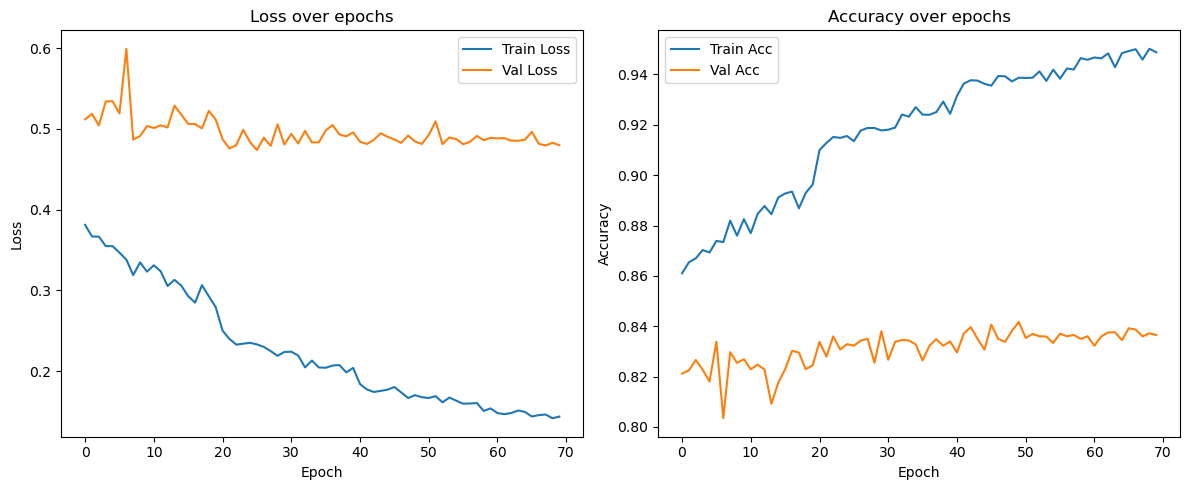

In [44]:
plot_loss_acc(train_losses, train_accs, val_losses, val_accs, "cnn_gru_model")

{'angry': 592, 'disgust': 592, 'fear': 592, 'happy': 592, 'neutral': 496, 'surprised': 592, 'sad': 592, 'calm': 192}


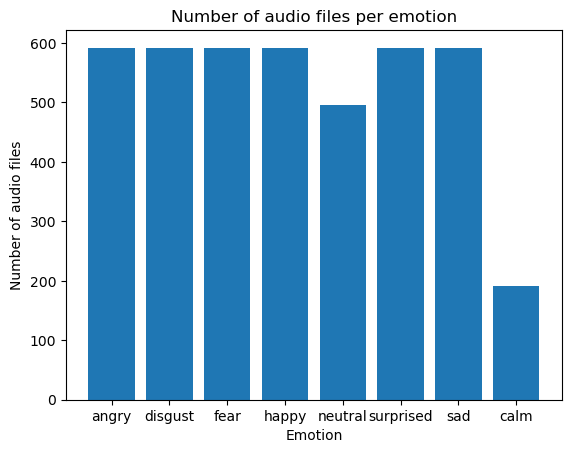

In [70]:
from collections import Counter
%matplotlib inline

counter = Counter(emotions)

counts = {emotion: counter[emotion] for emotion in emotions}
print(counts)

emotions_list = list(counts.keys())
count_emotions = list(counts.values())

plt.bar(emotions_list, count_emotions)

plt.xlabel("Emotion")
plt.ylabel("Number of audio files")
plt.title("Number of audio files per emotion")

plt.xticks()
plt.show()

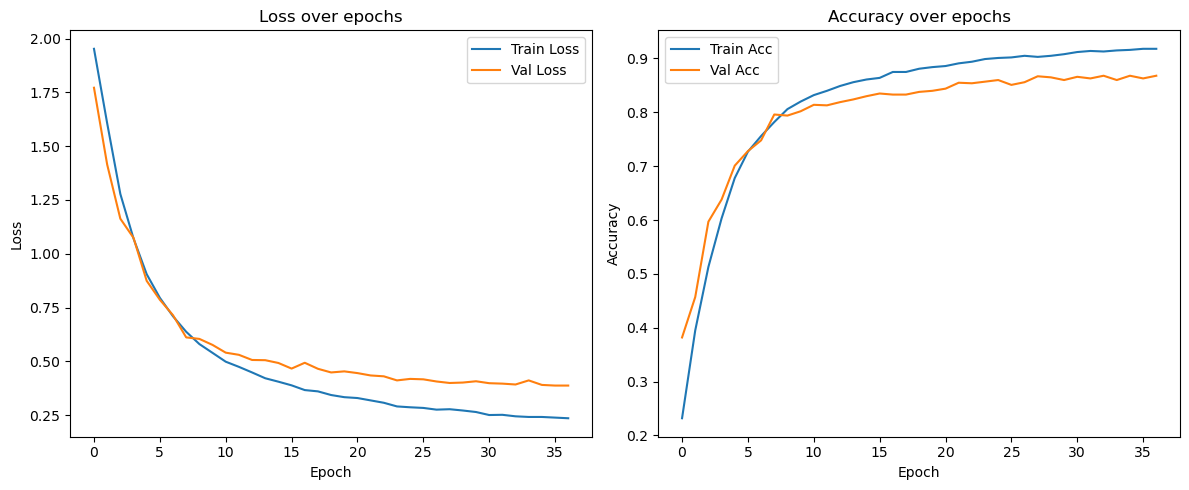

In [8]:
train_losses = [
    1.953, 1.607, 1.278, 1.071, 0.905, 0.795, 0.709, 0.637, 0.580, 0.539,
    0.498, 0.474, 0.448, 0.421, 0.405, 0.388, 0.366, 0.360, 0.343, 0.333,
    0.329, 0.318, 0.307, 0.290, 0.286, 0.283, 0.275, 0.277, 0.271, 0.264,
    0.250, 0.251, 0.244, 0.241, 0.241, 0.238, 0.235
]

train_accs = [
    0.232, 0.395, 0.513, 0.603, 0.678, 0.727, 0.756, 0.782, 0.806, 0.820,
    0.832, 0.840, 0.849, 0.856, 0.861, 0.864, 0.875, 0.875, 0.881, 0.884,
    0.886, 0.891, 0.894, 0.899, 0.901, 0.902, 0.905, 0.903, 0.905, 0.908,
    0.912, 0.914, 0.913, 0.915, 0.916, 0.918, 0.918
]

val_losses = [
    1.772, 1.415, 1.163, 1.074, 0.874, 0.786, 0.714, 0.611, 0.604, 0.576,
    0.540, 0.530, 0.506, 0.505, 0.492, 0.466, 0.493, 0.465, 0.448, 0.453,
    0.445, 0.434, 0.430, 0.411, 0.418, 0.416, 0.406, 0.399, 0.401, 0.407,
    0.398, 0.396, 0.392, 0.411, 0.390, 0.387, 0.387
]

val_accs = [
    0.382, 0.457, 0.597, 0.638, 0.701, 0.728, 0.748, 0.796, 0.794, 0.802,
    0.814, 0.813, 0.819, 0.824, 0.830, 0.835, 0.833, 0.833, 0.838, 0.840,
    0.844, 0.855, 0.854, 0.857, 0.860, 0.851, 0.856, 0.867, 0.865, 0.860,
    0.866, 0.863, 0.868, 0.860, 0.868, 0.863, 0.868
]

plot_loss_acc(train_losses, train_accs, val_losses, val_accs, "cnn_gru_model")

In [2]:
def plot_loss_acc(train_losses, train_accs, val_losses, val_accs, plot_name):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over epochs")
    #plt.savefig(plot_name+'_loss.jpg', dpi=500)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over epochs")

    plt.tight_layout()
    plt.savefig(plot_name + ".jpg", dpi=500)
    plt.show()

In [ ]:
from sklearn.metricssklearn.metrics importimport confusion_matrix
cm = confusion_matrix(y_true, preds)
cm = cm.astype("float64")
# Normalize each row
forfor i inin range(cm.shape[0]):
cm[i, :] = cm[i, :] / sum(cm[i, :])
cm